In [51]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import math
from scipy.stats import iqr
from numpy import linalg
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [14]:
## Features

def mean(x, y, z):
    """Calculates mean"""
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    mean_z = np.mean(z)
    return mean_x, mean_y, mean_z

def std_dev(x, y, z):
    """Calculates standard deviation"""
    std_x = np.std(x)
    std_y = np.std(y)
    std_z = np.std(z)
    return std_x, std_y, std_z  
    
def mad(x, y, z):
    """Calculates median absolute deviation"""
    mad_x = np.median(np.abs(x - np.median(x)))
    mad_y = np.median(np.abs(y - np.median(y)))
    mad_z = np.median(np.abs(z - np.median(z)))
    return mad_x, mad_y, mad_z

def minimum(x, y, z):
    """Calculates minimum"""
    return min(x), min(y), min(z)

def maximum(x, y, z):
    """Calculates maximum"""
    return max(x), max(y), max(z)

def energy_measure(x, y, z):
    """Calculates energy measures"""
    em_x = np.mean(np.square(x))
    em_y = np.mean(np.square(y))
    em_z = np.mean(np.square(z))
    return em_x, em_y, em_z

def inter_quartile_range(x, y, z):
    """Calculates inter-quartile range"""
    iqr_x = np.subtract(*np.percentile(x, [75, 25]))
    iqr_y = np.subtract(*np.percentile(y, [75, 25]))
    iqr_z = np.subtract(*np.percentile(z, [75, 25]))
    return iqr_x, iqr_y, iqr_z

def sma(x, y, z):
    """Calculates signal magnitude area"""   
    abs_x = np.absolute(x)
    abs_y = np.absolute(y)
    abs_z = np.absolute(z)
    return np.mean(abs_x+abs_y+abs_z)

In [15]:
def process_acc(input_df, columns, output_df):
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 5000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 2500
            max_window -= 2500
            i -= int(count/2)
        x = [input_df[1][i]]
        y = [input_df[2][i]]
        z = [input_df[3][i]]
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                x.append(input_df[1][i])
                y.append(input_df[2][i])
                z.append(input_df[3][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        label = (input_df[5][1], )
        if label == 'null':
            print('--------null')
            return
        sma_val = (sma(x,y,z), )
        acc_data = list(mean(x, y, z)+std_dev(x, y, z)+mad(x, y, z)+minimum(x, y, z)+maximum(x, y, z)+energy_measure(x, y, z)+inter_quartile_range(x, y, z)+sma_val)
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [16]:
def process_gyr(input_df, columns, output_df):

    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 5000
        min_window = input_df[0][i]
        if i != 0:                                                                 #handling overlap
            min_window -= 2500
            max_window -= 2500
            i -= int(count/2)
        x = [input_df[1][i]]
        y = [input_df[2][i]]
        z = [input_df[3][i]]
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                x.append(input_df[1][i])
                y.append(input_df[2][i])
                z.append(input_df[3][i])
                min_window = input_df[0][i]
            except KeyError:
                break
        
        
        label = (input_df[5][1], )
        if label == 'null':
            print('--------null')
            return
            
        sma_val = (sma(x,y,z), )

        gy_data = list(mean(x, y, z)+std_dev(x, y, z)+mad(x, y, z)+minimum(x, y, z)+maximum(x, y, z)+energy_measure(x, y, z)+inter_quartile_range(x, y, z)+sma_val+label) 
        output_df = output_df.append(pd.Series(gy_data, index=columns), ignore_index=True)
        
    return output_df

In [17]:
def process_mag(input_df, columns, output_df):
    mag = np.linalg.norm(input_df.iloc[:,1:4], axis = 1)
    input_df[6] = mag.tolist()
    
    i = 0
    while i < len(input_df[0]):
        max_window = input_df[0][i] + 5000
        min_window = input_df[0][i]
        if i != 0:                                  #handling overlap
            min_window -= 2500
            max_window -= 2500
            i -= int(count/2)
        x = [input_df[6][i]]
        
        
        count = 0
        while min_window < max_window:
            i += 1
            count += 1
            try:
                x.append(input_df[6][i])
                min_window = input_df[0][i]
            except KeyError:
                break
                
        label = (input_df[5][1], )
        if label == 'null':
            print('--------null')
            return
        
        mean = (np.mean(x),)
        std_dev = (np.std(x),)
        mad = (np.median(np.abs(x - np.median(x))),)
        minimum = (np.min(x),)
        maximum = (np.max(x),)
        energy_measure = (np.mean(np.square(x)),)
        inter_quartile_range = (np.subtract(*np.percentile(x, [75, 25])),)
        sma_val = (np.mean(np.absolute(x)),)
        acc_data = list(mean+std_dev+mad+minimum+maximum+energy_measure+inter_quartile_range+sma_val)
        output_df = output_df.append(pd.Series(acc_data, index=columns), ignore_index=True)

    return output_df

In [18]:
def hist_activities(df):
    df['label'].value_counts().plot(kind='bar', title='Training examples by activity type')
    plt.show()
    
def plot_activity(activity, df):
    data = df[df.iloc[:, 5] == activity][[1, 2, 3]][:2000]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_act_signals(df):
    plot_activity("sitting", df)
    plt.ylabel('sitting')
    plt.show()
    plot_activity("walking", df)
    plt.ylabel('walking')
    plt.show()
    plot_activity("standing", df)
    plt.ylabel('standing')
    plt.show()
    plot_activity("laying_down", df)
    plt.ylabel('laying_down')
    plt.show()

In [19]:
def calc_jerk(acc, ts):
    jk = [0]* len(acc)
    for i in range(1,len(acc)):
        jk[i-1] = 1000*(acc[i] - acc[i-1])/(ts[i] - ts[i-1])
    return jk

def fmagnitude(num):
    return math.sqrt(num.real**2 + num.imag**2)

In [20]:
def get_session_dirs(path):
    path = path
    dirs = []
    dir_list = [x[0] for x in os.walk(path)]
    last_dirs = ["1_android.sensor.accelerometer.data.csv.gz","4_android.sensor.gyroscope.data.csv.gz"]
    dirs = []
    for each_dir in dir_list[2:]:

        if "data" in each_dir:
            dirs.append(each_dir)

    dirs.sort(key=lambda x:x[-22:])
    return dirs

In [21]:
def get_jerk(df):
    df[1] = calc_jerk(df[1],df[0])
    df[2] = calc_jerk(df[2],df[0])
    df[3] = calc_jerk(df[3],df[0])
    return df

def get_fft(df):
    df[1] = np.fft.fft(df[1])
    df[2] = np.fft.fft(df[2])
    df[3] = np.fft.fft(df[3])
    df[1] = [fmagnitude(j) for j in df[1]]
    df[2] = [fmagnitude(j) for j in df[2]]
    df[3] = [fmagnitude(j) for j in df[3]]
    return df

In [30]:
tacc_cols = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z', 
               'std_acc_x', 'std_acc_y', 'std_acc_z', 
               'mad_acc_x', 'mad_acc_y', 'mad_acc_z',
               'min_acc_x', 'min_acc_y', 'min_acc_z', 
               'max_acc_x', 'max_acc_y', 'max_acc_z', 
               'em_acc_x', 'em_acc_y', 'em_acc_z', 
               'iqr_acc_x', 'iqr_acc_y', 'iqr_acc_z', 
               'sma_acc']

tacc_jerk_cols = ['mean_accj_x', 'mean_accj_y', 'mean_accj_z', 
                   'std_accj_x', 'std_accj_y', 'std_accj_z', 
                   'mad_accj_x', 'mad_accj_y', 'mad_accj_z',
                   'min_accj_x', 'min_accj_y', 'min_accj_z', 
                   'max_accj_x', 'max_accj_y', 'max_accj_z', 
                   'em_accj_x', 'em_accj_y', 'em_accj_z', 
                   'iqr_accj_x', 'iqr_accj_y', 'iqr_accj_z', 
                   'sma_accj']

tacc_mag_cols = ['mean_macc', 'std_macc', 'mad_macc', 'min_macc', 'max_macc', 'em_macc', 'iqr_macc', 'sma_macc']

tacc_jmag_cols = ['mean_macc_jerk', 'std_macc_jerk', 'mad_macc_jerk', 'min_macc_jerk', 'max_macc_jerk', 
                     'em_macc_jerk', 'iqr_macc_jerk', 'sma_macc_jerk']

facc_cols = ['mean_facc_x', 'mean_facc_y', 'mean_facc_z', 
               'std_facc_x', 'std_facc_y', 'std_facc_z', 
               'mad_facc_x', 'mad_facc_y', 'mad_facc_z',
               'min_facc_x', 'min_facc_y', 'min_facc_z', 
               'max_facc_x', 'max_facc_y', 'max_facc_z', 
               'em_facc_x', 'em_facc_y', 'em_facc_z', 
               'iqr_facc_x', 'iqr_facc_y', 'iqr_facc_z', 
               'sma_facc']

facc_jerk_cols = ['mean_faccj_x', 'mean_faccj_y', 'mean_faccj_z', 
                   'std_faccj_x', 'std_faccj_y', 'std_faccj_z', 
                   'mad_faccj_x', 'mad_faccj_y', 'mad_faccj_z',
                   'min_faccj_x', 'min_faccj_y', 'min_faccj_z', 
                   'max_faccj_x', 'max_faccj_y', 'max_faccj_z', 
                   'em_faccj_x', 'em_faccj_y', 'em_faccj_z', 
                   'iqr_faccj_x', 'iqr_faccj_y', 'iqr_faccj_z', 
                   'sma_faccj']

facc_mag_cols = ['mean_mfacc', 'std_mfacc', 'mad_mfacc', 'min_mfacc', 'max_mfacc', 'em_mfacc', 'iqr_mfacc', 'sma_mfacc']

facc_jmag_cols = ['mean_mfacc_jerk', 'std_mfacc_jerk', 'mad_mfacc_jerk', 'min_mfacc_jerk', 'max_mfacc_jerk', 
                     'em_mfacc_jerk', 'iqr_mfacc_jerk', 'sma_mfacc_jerk']

tgy_cols = ['mean_gy_x', 'mean_gy_y', 'mean_gy_z', 
               'std_gy_x', 'std_gy_y', 'std_gy_z', 
               'mad_gy_x', 'mad_gy_y', 'mad_gy_z',
               'min_gy_x', 'min_gy_y', 'min_gy_z', 
               'max_gy_x', 'max_gy_y', 'max_gy_z', 
               'em_gy_x', 'em_gy_y', 'em_gy_z', 
               'iqr_gy_x', 'iqr_gy_y', 'iqr_gy_z', 
               'sma_gy', 'label']

tgy_jerk_cols = ['mean_gyj_x', 'mean_gyj_y', 'mean_gyj_z', 
                   'std_gyj_x', 'std_gyj_y', 'std_gyj_z', 
                   'mad_gyj_x', 'mad_gyj_y', 'mad_gyj_z',
                   'min_gyj_x', 'min_gyj_y', 'min_gyj_z', 
                   'max_gyj_x', 'max_gyj_y', 'max_gyj_z', 
                   'em_gyj_x', 'em_gyj_y', 'em_gyj_z', 
                   'iqr_gyj_x', 'iqr_gyj_y', 'iqr_gyj_z', 
                   'sma_gyj']

tgy_mag_cols = ['mean_mgy', 'std_mgy', 'mad_mgy', 'min_mgy', 'max_mgy', 'em_mgy', 'iqr_mgy', 'sma_mgy']

tgy_jmag_cols = ['mean_mgy_jerk', 'std_mgy_jerk', 'mad_mgy_jerk', 'min_mgy_jerk', 'max_mgy_jerk', 
                     'em_mgy_jerk', 'iqr_mgy_jerk', 'sma_mgy_jerk']
fgy_cols = ['mean_fgy_x', 'mean_fgy_y', 'mean_fgy_z', 
               'std_fgy_x', 'std_fgy_y', 'std_fgy_z', 
               'mad_fgy_x', 'mad_fgy_y', 'mad_fgy_z',
               'min_fgy_x', 'min_fgy_y', 'min_fgy_z', 
               'max_fgy_x', 'max_fgy_y', 'max_fgy_z', 
               'em_fgy_x', 'em_fgy_y', 'em_fgy_z', 
               'iqr_fgy_x', 'iqr_fgy_y', 'iqr_fgy_z', 
               'sma_fgy']

fgy_jerk_cols = ['mean_fgyj_x', 'mean_fgyj_y', 'mean_fgyj_z', 
                   'std_fgyj_x', 'std_fgyj_y', 'std_fgyj_z', 
                   'mad_fgyj_x', 'mad_fgyj_y', 'mad_fgyj_z',
                   'min_fgyj_x', 'min_fgyj_y', 'min_fgyj_z', 
                   'max_fgyj_x', 'max_fgyj_y', 'max_fgyj_z', 
                   'em_fgyj_x', 'em_fgyj_y', 'em_fgyj_z', 
                   'iqr_fgyj_x', 'iqr_fgyj_y', 'iqr_fgyj_z', 
                   'sma_fgyj']

fgy_mag_cols = ['mean_mfgy', 'std_mfgy', 'mad_mfgy', 'min_mfgy', 'max_mfgy', 'em_mfgy', 'iqr_mfgy', 'sma_mfgy']

fgy_jmag_cols = ['mean_mfgy_jerk', 'std_mfgy_jerk', 'mad_mfgy_jerk', 'min_mfgy_jerk', 'max_mfgy_jerk', 
                     'em_mfgy_jerk', 'iqr_mfgy_jerk', 'sma_mfgy_jerk']


In [31]:
def process_csv_data(path):
    dirs = get_session_dirs(path)

    tacc_cols = ['mean_acc_x', 'mean_acc_y', 'mean_acc_z', 
               'std_acc_x', 'std_acc_y', 'std_acc_z', 
               'mad_acc_x', 'mad_acc_y', 'mad_acc_z',
               'min_acc_x', 'min_acc_y', 'min_acc_z', 
               'max_acc_x', 'max_acc_y', 'max_acc_z', 
               'em_acc_x', 'em_acc_y', 'em_acc_z', 
               'iqr_acc_x', 'iqr_acc_y', 'iqr_acc_z', 
               'sma_acc']
    out_acc_df = pd.DataFrame(columns = tacc_cols)

    tacc_jerk_cols = ['mean_accj_x', 'mean_accj_y', 'mean_accj_z', 
                   'std_accj_x', 'std_accj_y', 'std_accj_z', 
                   'mad_accj_x', 'mad_accj_y', 'mad_accj_z',
                   'min_accj_x', 'min_accj_y', 'min_accj_z', 
                   'max_accj_x', 'max_accj_y', 'max_accj_z', 
                   'em_accj_x', 'em_accj_y', 'em_accj_z', 
                   'iqr_accj_x', 'iqr_accj_y', 'iqr_accj_z', 
                   'sma_accj']
    out_acc_jerk_df = pd.DataFrame(columns = tacc_jerk_cols)

    tacc_mag_cols = ['mean_macc', 'std_macc', 'mad_macc', 'min_macc', 'max_macc', 'em_macc', 'iqr_macc', 'sma_macc']
    acc_mag = pd.DataFrame(columns = tacc_mag_cols)

    tacc_jmag_cols = ['mean_macc_jerk', 'std_macc_jerk', 'mad_macc_jerk', 'min_macc_jerk', 'max_macc_jerk', 
                     'em_macc_jerk', 'iqr_macc_jerk', 'sma_macc_jerk']
    acc_jerk_mag = pd.DataFrame(columns = tacc_jmag_cols)

    facc_cols = ['mean_facc_x', 'mean_facc_y', 'mean_facc_z', 
               'std_facc_x', 'std_facc_y', 'std_facc_z', 
               'mad_facc_x', 'mad_facc_y', 'mad_facc_z',
               'min_facc_x', 'min_facc_y', 'min_facc_z', 
               'max_facc_x', 'max_facc_y', 'max_facc_z', 
               'em_facc_x', 'em_facc_y', 'em_facc_z', 
               'iqr_facc_x', 'iqr_facc_y', 'iqr_facc_z', 
               'sma_facc']
    out_facc_df = pd.DataFrame(columns = facc_cols)

    facc_jerk_cols = ['mean_faccj_x', 'mean_faccj_y', 'mean_faccj_z', 
                   'std_faccj_x', 'std_faccj_y', 'std_faccj_z', 
                   'mad_faccj_x', 'mad_faccj_y', 'mad_faccj_z',
                   'min_faccj_x', 'min_faccj_y', 'min_faccj_z', 
                   'max_faccj_x', 'max_faccj_y', 'max_faccj_z', 
                   'em_faccj_x', 'em_faccj_y', 'em_faccj_z', 
                   'iqr_faccj_x', 'iqr_faccj_y', 'iqr_faccj_z', 
                   'sma_faccj']
    out_facc_jerk_df = pd.DataFrame(columns = facc_jerk_cols)

    facc_mag_cols = ['mean_mfacc', 'std_mfacc', 'mad_mfacc', 'min_mfacc', 'max_mfacc', 'em_mfacc', 'iqr_mfacc', 'sma_mfacc']
    facc_mag = pd.DataFrame(columns = facc_mag_cols)

    facc_jmag_cols = ['mean_mfacc_jerk', 'std_mfacc_jerk', 'mad_mfacc_jerk', 'min_mfacc_jerk', 'max_mfacc_jerk', 
                     'em_mfacc_jerk', 'iqr_mfacc_jerk', 'sma_mfacc_jerk']
    facc_jerk_mag = pd.DataFrame(columns = facc_jmag_cols)

    tgy_cols = ['mean_gy_x', 'mean_gy_y', 'mean_gy_z', 
               'std_gy_x', 'std_gy_y', 'std_gy_z', 
               'mad_gy_x', 'mad_gy_y', 'mad_gy_z',
               'min_gy_x', 'min_gy_y', 'min_gy_z', 
               'max_gy_x', 'max_gy_y', 'max_gy_z', 
               'em_gy_x', 'em_gy_y', 'em_gy_z', 
               'iqr_gy_x', 'iqr_gy_y', 'iqr_gy_z', 
               'sma_gy', 'label']
    out_gy_df = pd.DataFrame(columns = tgy_cols)

    tgy_jerk_cols = ['mean_gyj_x', 'mean_gyj_y', 'mean_gyj_z', 
                   'std_gyj_x', 'std_gyj_y', 'std_gyj_z', 
                   'mad_gyj_x', 'mad_gyj_y', 'mad_gyj_z',
                   'min_gyj_x', 'min_gyj_y', 'min_gyj_z', 
                   'max_gyj_x', 'max_gyj_y', 'max_gyj_z', 
                   'em_gyj_x', 'em_gyj_y', 'em_gyj_z', 
                   'iqr_gyj_x', 'iqr_gyj_y', 'iqr_gyj_z', 
                   'sma_gyj']
    out_gy_jerk_df = pd.DataFrame(columns = tgy_jerk_cols)

    tgy_mag_cols = ['mean_mgy', 'std_mgy', 'mad_mgy', 'min_mgy', 'max_mgy', 'em_mgy', 'iqr_mgy', 'sma_mgy']
    gy_mag = pd.DataFrame(columns = tgy_mag_cols)

    tgy_jmag_cols = ['mean_mgy_jerk', 'std_mgy_jerk', 'mad_mgy_jerk', 'min_mgy_jerk', 'max_mgy_jerk', 
                     'em_mgy_jerk', 'iqr_mgy_jerk', 'sma_mgy_jerk']
    gy_jerk_mag = pd.DataFrame(columns = tgy_jmag_cols)

    fgy_cols = ['mean_fgy_x', 'mean_fgy_y', 'mean_fgy_z', 
               'std_fgy_x', 'std_fgy_y', 'std_fgy_z', 
               'mad_fgy_x', 'mad_fgy_y', 'mad_fgy_z',
               'min_fgy_x', 'min_fgy_y', 'min_fgy_z', 
               'max_fgy_x', 'max_fgy_y', 'max_fgy_z', 
               'em_fgy_x', 'em_fgy_y', 'em_fgy_z', 
               'iqr_fgy_x', 'iqr_fgy_y', 'iqr_fgy_z', 
               'sma_fgy']
    out_fgy_df = pd.DataFrame(columns = fgy_cols)

    fgy_jerk_cols = ['mean_fgyj_x', 'mean_fgyj_y', 'mean_fgyj_z', 
                   'std_fgyj_x', 'std_fgyj_y', 'std_fgyj_z', 
                   'mad_fgyj_x', 'mad_fgyj_y', 'mad_fgyj_z',
                   'min_fgyj_x', 'min_fgyj_y', 'min_fgyj_z', 
                   'max_fgyj_x', 'max_fgyj_y', 'max_fgyj_z', 
                   'em_fgyj_x', 'em_fgyj_y', 'em_fgyj_z', 
                   'iqr_fgyj_x', 'iqr_fgyj_y', 'iqr_fgyj_z', 
                   'sma_fgyj']
    out_fgy_jerk_df = pd.DataFrame(columns = fgy_jerk_cols)

    fgy_mag_cols = ['mean_mfgy', 'std_mfgy', 'mad_mfgy', 'min_mfgy', 'max_mfgy', 'em_mfgy', 'iqr_mfgy', 'sma_mfgy']
    fgy_mag = pd.DataFrame(columns = fgy_mag_cols)

    fgy_jmag_cols = ['mean_mfgy_jerk', 'std_mfgy_jerk', 'mad_mfgy_jerk', 'min_mfgy_jerk', 'max_mfgy_jerk', 
                     'em_mfgy_jerk', 'iqr_mfgy_jerk', 'sma_mfgy_jerk']
    fgy_jerk_mag = pd.DataFrame(columns = fgy_jmag_cols)


    acc_gy_df = pd.DataFrame()

    for i in dirs: 
        full_path_acc = os.path.normpath(i + "/" + "1_android.sensor.accelerometer.data.csv.gz")
        full_path_gy = os.path.normpath(i + "/" + "4_android.sensor.gyroscope.data.csv.gz")

        print("processing acceleration: " + full_path_acc)
        in_df_ac = pd.read_csv(full_path_acc, compression='gzip', sep=',', header=None)

        in_df_ac_jerk = in_df_ac.copy()
        in_df_ac_jerk = get_jerk(in_df_ac_jerk)

        in_df_fac = in_df_ac.copy()
        in_df_fac = get_fft(in_df_fac)

        in_df_fac_jerk = in_df_ac_jerk.copy()
        in_df_fac_jerk = get_fft(in_df_fac_jerk)

        out_acc_df = process_acc(in_df_ac, tacc_cols, out_acc_df)
        out_acc_jerk_df = process_acc(in_df_ac_jerk, tacc_jerk_cols, out_acc_jerk_df)
        out_facc_df = process_acc(in_df_fac, facc_cols, out_facc_df)
        out_facc_jerk_df = process_acc(in_df_fac_jerk, facc_jerk_cols, out_facc_jerk_df)

        acc_mag = process_mag(in_df_ac, tacc_mag_cols, acc_mag)
        acc_jerk_mag = process_mag(in_df_ac_jerk, tacc_jmag_cols, acc_jerk_mag)
        facc_mag = process_mag(in_df_fac, facc_mag_cols, facc_mag)
        facc_jerk_mag = process_mag(in_df_fac_jerk, facc_jmag_cols, facc_jerk_mag)

        print("processing gyroscope: " + full_path_gy)
        in_df_gy = pd.read_csv(full_path_gy, compression='gzip', sep=',', header=None)

        in_df_gy_jerk = in_df_gy.copy()
        in_df_gy_jerk = get_jerk(in_df_gy_jerk)

        in_df_fgy = in_df_gy.copy()
        in_df_fgy = get_fft(in_df_fgy)

        in_df_fgy_jerk = in_df_gy_jerk.copy()
        in_df_fgy_jerk = get_fft(in_df_fgy_jerk)

        out_gy_df = process_gyr(in_df_gy, tgy_cols, out_gy_df)
        out_gy_jerk_df = process_acc(in_df_gy_jerk, tgy_jerk_cols, out_gy_jerk_df)
        out_fgy_df = process_acc(in_df_fgy, fgy_cols, out_fgy_df)
        out_fgy_jerk_df = process_acc(in_df_fgy_jerk, fgy_jerk_cols, out_fgy_jerk_df)

        gy_mag = process_mag(in_df_gy, tgy_mag_cols, gy_mag)
        gy_jerk_mag = process_mag(in_df_gy_jerk, tgy_jmag_cols, gy_jerk_mag)
        fgy_mag = process_mag(in_df_fgy, fgy_mag_cols, fgy_mag)
        fgy_jerk_mag = process_mag(in_df_fgy_jerk, fgy_jmag_cols, fgy_jerk_mag)


        #handling mismatch in rows
        if out_gy_df.shape[0] < out_acc_df.shape[0]:
            out_acc_df = out_acc_df[:out_gy_df.shape[0]]
            out_acc_jerk_df = out_acc_jerk_df[:out_gy_df.shape[0]]
            out_facc_df = out_facc_df[:out_gy_df.shape[0]]
            out_facc_jerk_df = out_facc_jerk_df[:out_gy_df.shape[0]]
            acc_mag = acc_mag[:out_gy_df.shape[0]]
            acc_jerk_mag = acc_jerk_mag[:out_gy_df.shape[0]]
            facc_mag = facc_mag[:out_gy_df.shape[0]]
            facc_jerk_mag = facc_jerk_mag[:out_gy_df.shape[0]]

        acc_gy_df = pd.concat([out_acc_df, acc_mag, out_acc_jerk_df, acc_jerk_mag, 
                               out_facc_df, facc_mag, out_facc_jerk_df, facc_jerk_mag,
                               out_gy_df, gy_mag, out_gy_jerk_df, gy_jerk_mag, 
                               out_fgy_df, fgy_mag, out_fgy_jerk_df, fgy_jerk_mag], axis=1)

    print(acc_gy_df.shape)
    return acc_gy_df

In [32]:
training_set_df = process_csv_data('newData/')

processing acceleration: newData/14442D4AF81DBE4_Thu_Mar_01_20-47_2018_PST/data/1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: newData/14442D4AF81DBE4_Thu_Mar_01_20-47_2018_PST/data/4_android.sensor.gyroscope.data.csv.gz
processing acceleration: newData/14442D4AF81DBE4_Fri_Mar_02_01-53_2018_PST/data/1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: newData/14442D4AF81DBE4_Fri_Mar_02_01-53_2018_PST/data/4_android.sensor.gyroscope.data.csv.gz
processing acceleration: newData/14442D4AF81DBE4_Fri_Mar_02_02-08_2018_PST/data/1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: newData/14442D4AF81DBE4_Fri_Mar_02_02-08_2018_PST/data/4_android.sensor.gyroscope.data.csv.gz
processing acceleration: newData/14442D4AF81DBE4_Wed_Mar_07_22-13_2018_PST/data/1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: newData/14442D4AF81DBE4_Wed_Mar_07_22-13_2018_PST/data/4_android.sensor.gyroscope.data.csv.gz
processing acceleration: newData/14442D4AF81

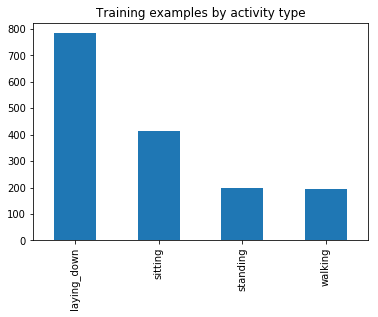

,mean_acc_x,mean_acc_y,mean_acc_z,std_acc_x,std_acc_y,std_acc_z,mad_acc_x,mad_acc_y,mad_acc_z,min_acc_x,...,iqr_fgyj_z,sma_fgyj,mean_mfgy_jerk,std_mfgy_jerk,mad_mfgy_jerk,min_mfgy_jerk,max_mfgy_jerk,em_mfgy_jerk,iqr_mfgy_jerk,sma_mfgy_jerk
339,0.360488,-1.950014,9.311011,0.094237,0.957671,0.220359,0.047873,0.067022,0.038298,0.196278,...,641.011653,3214.331536,2128.397958,795.946140,504.464148,582.700522,6105.570927,5.163608e+06,1009.048961,2128.397958
258,4.905650,-5.881653,-0.608753,3.340212,4.383850,3.400998,0.919158,1.225543,2.001083,0.847349,...,512.181438,2841.728448,1811.873744,515.555432,346.511620,515.225602,3597.059207,3.548684e+06,679.117139,1811.873744
1292,7.503544,5.313811,3.132306,1.179839,1.300254,1.054429,0.057447,0.229789,0.220215,0.560112,...,678.757019,3849.130005,2628.112796,997.484230,682.332260,596.385964,6388.855972,7.901952e+06,1380.867282,2628.112796
939,-5.630273,6.530054,3.581890,0.203013,0.251325,0.288259,0.114895,0.090958,0.110107,-6.323997,...,147.055341,801.465574,514.328052,151.373452,104.252077,175.797025,939.903699,2.874473e+05,209.993878,514.328052
753,3.780938,7.502748,4.095317,1.542986,1.439791,1.434166,1.110649,0.928732,0.450004,0.722879,...,119.705879,678.615495,435.853456,133.129183,85.924568,78.109335,911.172115,2.076916e+05,180.530743,435.853456


In [38]:
hist_activities(training_set_df)
# plot_act_signals(in_df_ac)

combined_training_df = training_set_df
combined_training_df = combined_training_df.iloc[np.random.permutation(len(combined_training_df))]
combined_training_df.head()

In [43]:
## Training set

training_data = combined_training_df[tacc_cols+tacc_jerk_cols+tacc_mag_cols+tacc_jmag_cols+facc_cols+facc_jerk_cols+facc_mag_cols+facc_jmag_cols+tgy_jerk_cols+tgy_mag_cols+tgy_jmag_cols+fgy_cols+fgy_jerk_cols+fgy_mag_cols+fgy_jmag_cols+tgy_cols].as_matrix()
training_targets = training_data[:, -1]
training_data = training_data[:, :-1]

std_scale = preprocessing.StandardScaler().fit(training_data)
training_data_std = std_scale.transform(training_data)

print(len(training_data_std), len(training_data_std[0]))
print(len(training_targets))

cache = {'laying_down' : 0, 'sitting' : 1, 'walking' : 2, 'standing' : 3}
training_targets.reshape(len(training_targets))
print(training_targets)
print(training_targets.shape)

training_bin_targets = []
for i in training_targets:
    training_bin_targets.append(cache[i])
print(len(training_bin_targets))

training_bin_targets[: 5]

1589 240
1589
['sitting' 'sitting' 'laying_down' ..., 'laying_down' 'laying_down'
 'laying_down']
(1589,)
1589


/Users/gringotts/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[1, 1, 0, 0, 0]

In [44]:
## Testing set
testing_set_df = process_csv_data('test/')

processing acceleration: test/14442D57F7E1B88_Thu_Feb_08_00-18_2018_PST/data/1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: test/14442D57F7E1B88_Thu_Feb_08_00-18_2018_PST/data/4_android.sensor.gyroscope.data.csv.gz
processing acceleration: test/14442D57F7E1B88_Thu_Feb_08_00-39_2018_PST/data/1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: test/14442D57F7E1B88_Thu_Feb_08_00-39_2018_PST/data/4_android.sensor.gyroscope.data.csv.gz
processing acceleration: test/14442D57F7E1B88_Fri_Feb_16_14-11_2018_PST/data/1_android.sensor.accelerometer.data.csv.gz
processing gyroscope: test/14442D57F7E1B88_Fri_Feb_16_14-11_2018_PST/data/4_android.sensor.gyroscope.data.csv.gz
(246, 241)


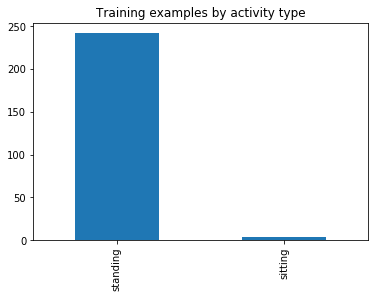

,mean_acc_x,mean_acc_y,mean_acc_z,std_acc_x,std_acc_y,std_acc_z,mad_acc_x,mad_acc_y,mad_acc_z,min_acc_x,...,iqr_fgyj_z,sma_fgyj,mean_mfgy_jerk,std_mfgy_jerk,mad_mfgy_jerk,min_mfgy_jerk,max_mfgy_jerk,em_mfgy_jerk,iqr_mfgy_jerk,sma_mfgy_jerk
85,0.206530,-6.814763,-2.353833,4.598377,2.044907,5.118671,2.048956,1.072351,2.604280,-7.013366,...,1806.040401,8168.875032,5113.941227,1534.619325,946.388496,1592.085381,11032.792189,2.850745e+07,1887.351982,5113.941227
107,-3.651565,2.390851,-9.020373,0.037610,0.043738,0.038354,0.028723,0.028724,0.028724,-3.767590,...,1640.117008,7010.869674,4421.280141,1385.158154,929.259582,1123.174208,8832.009682,2.146638e+07,1853.761025,4421.280141
125,-2.930793,-7.012911,-0.307209,2.532693,6.552819,3.585397,0.067022,0.047873,0.047873,-14.874080,...,1687.355234,7799.829138,4954.767362,1655.082000,1117.267418,1120.156366,10982.550392,2.728902e+07,2257.807732,4954.767362
1,-4.285047,1.451027,7.935361,0.098963,0.090016,0.135016,0.057447,0.057447,0.057447,-4.705896,...,18.551864,92.063272,57.497682,18.355439,12.743568,14.214841,116.717418,3.642906e+03,25.072074,57.497682
234,0.336415,-1.064921,6.271967,5.310597,4.365678,4.310651,1.474482,2.690451,1.627675,-19.603912,...,5660.589551,24688.452053,15411.506969,4647.061636,3257.082876,5022.922291,32691.057397,2.591097e+08,6488.583965,15411.506969


In [45]:
hist_activities(testing_set_df)
# plot_act_signals(in_df_ac)

combined_testing_df = testing_set_df
combined_testing_df = combined_testing_df.iloc[np.random.permutation(len(combined_testing_df))]
combined_testing_df.head()

In [47]:
testing_data = combined_testing_df[tacc_cols+tacc_jerk_cols+tacc_mag_cols+tacc_jmag_cols+facc_cols+facc_jerk_cols+facc_mag_cols+facc_jmag_cols+tgy_jerk_cols+tgy_mag_cols+tgy_jmag_cols+fgy_cols+fgy_jerk_cols+fgy_mag_cols+fgy_jmag_cols+tgy_cols].as_matrix()
testing_targets = testing_data[:, -1]
testing_data = testing_data[:, :-1]

std_scale = preprocessing.StandardScaler().fit(testing_data)
testing_data_std = std_scale.transform(testing_data)

print(len(testing_data_std), len(testing_data_std[0]))
print(len(testing_targets))

cache = {'laying_down' : 0, 'sitting' : 1, 'walking' : 2, 'standing' : 3}
testing_targets.reshape(len(testing_targets))
print(testing_targets.shape)

testing_bin_targets = []
for i in testing_targets:
    testing_bin_targets.append(cache[i])
print(len(testing_bin_targets))

testing_bin_targets[: 5]

246 240
246
(246,)
246


/Users/gringotts/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[3, 3, 3, 1, 3]

In [60]:
model = DecisionTreeClassifier(random_state=0)

# Training the model
model.fit(training_data, training_bin_targets)

# Testing on the testing data
predicted_values = model.predict(testing_data)

In [62]:
acc_score = accuracy_score(testing_bin_targets, predicted_values)
print("Score: ", acc_score)

Score:  0.373983739837
